In [ ]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [ ]:
!nvidia-smi

Tue May 31 21:52:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and Fixing the data

In [ ]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
!gdown --id '1HuthY7iMaKLWqPffAAQOxydr-fhgQyzl' --o '/content/sample_data/AFFINE_REG_SKS_MASK_2D.zip' --q
!unzip -q '/content/sample_data/AFFINE_REG_SKS_MASK_2D.zip' -d '/content/sample_data/'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,


In [ ]:
root = '/content/sample_data/AFFINE_REG_SKS_MASK_2D/'
data = testing = pd.read_csv('/content/drive/MyDrive/ADNI/MY_ADNI_CLEAN.csv')
x_train, x_test, y_train, y_test = train_test_split(data[['Image Data ID']].values, data[['Group']].values, test_size=0.20, random_state=13 )

training = flatten(x_train.tolist())
testing = flatten(x_test.tolist())
data.loc[data['Image Data ID'].isin(training)].to_csv('/content/sample_data/training.csv', index=False, encoding='utf-8-sig')
data.loc[data['Image Data ID'].isin(testing)].to_csv('/content/sample_data/testing.csv', index=False, encoding='utf-8-sig')
traning = pd.read_csv('/content/sample_data/training.csv')
testing = pd.read_csv('/content/sample_data/testing.csv')

image_Shape=(436,364,3)

In [ ]:
l = ['/testing/CN/','/testing/AD/','/testing/MCI/','/training/CN/','/training/AD/','/training/MCI/']
for elem in l:
  if not os.path.isdir(root+elem):
      os.makedirs(root+elem)
      
for index ,row in traning.iterrows():
  shutil.move(f'{root}{row["Image Data ID"]}.png',f'{root}training/{row["Group"]}/{row["Image Data ID"]}.png')
  

for index ,row in testing.iterrows():
  shutil.move(f'{root}{row["Image Data ID"]}.png',f'{root}testing/{row["Group"]}/{row["Image Data ID"]}.png')
  

# Models

In [ ]:
def resnet50_pretrained(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = False
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [ ]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 2789 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
training_image_datagen.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

In [ ]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

# **Resnet 50 pretrained**

### learning_rate=10E-4

In [ ]:
# learning_rate=10E-4
savepath = '/content/drive/MyDrive/ADNI/resnet50_pretrained_10E-4/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_pretrained_10E-4_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model01 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
history01 = model01.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model01 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
model01.load_weights(glob.glob(f"{savepath}resnet50_pretrained_10E-4_weights-epoch:*-val_Accuracy:{max(history01.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
698/698 [==============================] - 72s 81ms/step - loss: 12.8523 - Accuracy: 0.4690 - AD_Precision: 0.2717 - CN_Precision: 0.4260 - MCI_Precision: 0.5622 - AD_Recall: 0.2465 - CN_Recall: 0.4140 - MCI_Recall: 0.5634 - val_loss: 1.5681 - val_Accuracy: 0.4040 - val_AD_Precision: 0.7500 - val_CN_Precision: 0.3298 - val_MCI_Precision: 0.7870 - val_AD_Recall: 0.0236 - val_CN_Recall: 0.9442 - val_MCI_Recall: 0.2273
Epoch 2/50
698/698 [==============================] - 53s 75ms/step - loss: 1.7410 - Accuracy: 0.5342 - AD_Precision: 0.3543 - CN_Precision: 0.5111 - MCI_Precision: 0.6120 - AD_Recall: 0.3116 - CN_Recall: 0.4830 - MCI_Recall: 0.6125 - val_loss: 2.3237 - val_Accuracy: 0.3453 - val_AD_Precision: 0.2332 - val_CN_Precision: 1.0000 - val_MCI_Precision: 0.6279 - val_AD_Recall: 0.9291 - val_CN_Recall: 0.0609 - val_MCI_Recall: 0.2888
Epoch 3/50
698/698 [==============================] - 52s 75ms/step - loss: 2.4042 - Accuracy: 0.5561 - AD_Precision: 0.3603 - CN_Precision

              precision    recall  f1-score   support

          AD       0.94      0.71      0.81       127
          CN       0.87      0.94      0.91       197
         MCI       0.91      0.95      0.93       374

    accuracy                           0.90       698
   macro avg       0.91      0.87      0.88       698
weighted avg       0.90      0.90      0.90       698



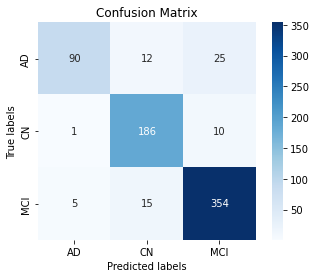

In [ ]:
p = model01.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

### learning_rate=10E-5

In [ ]:
# learning_rate=10E-5
savepath = '/content/drive/MyDrive/ADNI/resnet50_pretrained_10E-5/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_pretrained_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model02 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
history02 = model02.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model02 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
model02.load_weights(glob.glob(f"{savepath}resnet50_pretrained_10E-5_weights-epoch:*-val_Accuracy:{max(history02.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
698/698 [==============================] - 59s 79ms/step - loss: 7.0761 - Accuracy: 0.5707 - AD_Precision: 0.4087 - CN_Precision: 0.5239 - MCI_Precision: 0.6551 - AD_Recall: 0.3991 - CN_Recall: 0.5200 - MCI_Recall: 0.6602 - val_loss: 4.2220 - val_Accuracy: 0.4298 - val_AD_Precision: 0.2551 - val_CN_Precision: 0.7087 - val_MCI_Precision: 0.7655 - val_AD_Recall: 0.8898 - val_CN_Recall: 0.3706 - val_MCI_Recall: 0.2968
Epoch 2/50
698/698 [==============================] - 55s 78ms/step - loss: 3.4269 - Accuracy: 0.6052 - AD_Precision: 0.4687 - CN_Precision: 0.5794 - MCI_Precision: 0.6716 - AD_Recall: 0.4576 - CN_Recall: 0.5801 - MCI_Recall: 0.6692 - val_loss: 4.2318 - val_Accuracy: 0.4169 - val_AD_Precision: 0.2532 - val_CN_Precision: 0.9545 - val_MCI_Precision: 0.7260 - val_AD_Recall: 0.9291 - val_CN_Recall: 0.1066 - val_MCI_Recall: 0.4037
Epoch 3/50
698/698 [==============================] - 54s 78ms/step - loss: 2.2227 - Accuracy: 0.6737 - AD_Precision: 0.5582 - CN_Precision:

              precision    recall  f1-score   support

          AD       0.90      0.85      0.87       127
          CN       0.94      0.89      0.91       197
         MCI       0.92      0.96      0.94       374

    accuracy                           0.92       698
   macro avg       0.92      0.90      0.91       698
weighted avg       0.92      0.92      0.92       698



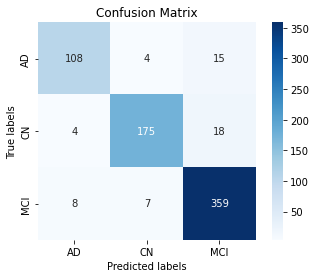

In [ ]:
p = model02.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

### learning_rate=10E-6

In [ ]:
# learning_rate=10E-6
savepath = '/content/drive/MyDrive/ADNI/resnet50_pretrained_10E-6/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_pretrained_10E-6_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model03 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = resnet50_pretrained(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}resnet50_pretrained_10E-6_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
698/698 [==============================] - 61s 80ms/step - loss: 3.5724 - Accuracy: 0.5139 - AD_Precision: 0.3558 - CN_Precision: 0.4495 - MCI_Precision: 0.6105 - AD_Recall: 0.3407 - CN_Recall: 0.4354 - MCI_Recall: 0.6135 - val_loss: 2.0704 - val_Accuracy: 0.4585 - val_AD_Precision: 0.6000 - val_CN_Precision: 0.3526 - val_MCI_Precision: 0.7105 - val_AD_Recall: 0.1181 - val_CN_Recall: 0.8376 - val_MCI_Recall: 0.3610
Epoch 2/50
698/698 [==============================] - 54s 78ms/step - loss: 2.8304 - Accuracy: 0.5009 - AD_Precision: 0.3221 - CN_Precision: 0.4561 - MCI_Precision: 0.5924 - AD_Recall: 0.3018 - CN_Recall: 0.4433 - MCI_Recall: 0.5929 - val_loss: 1.2083 - val_Accuracy: 0.6218 - val_AD_Precision: 0.5625 - val_CN_Precision: 0.5273 - val_MCI_Precision: 0.6997 - val_AD_Recall: 0.1417 - val_CN_Recall: 0.6853 - val_MCI_Recall: 0.7166
Epoch 3/50
698/698 [==============================] - 55s 78ms/step - loss: 2.3611 - Accuracy: 0.5489 - AD_Precision: 0.4044 - CN_Precision:

              precision    recall  f1-score   support

          AD       0.89      0.87      0.88       127
          CN       0.96      0.89      0.92       197
         MCI       0.93      0.97      0.95       374

    accuracy                           0.93       698
   macro avg       0.92      0.91      0.92       698
weighted avg       0.93      0.93      0.93       698



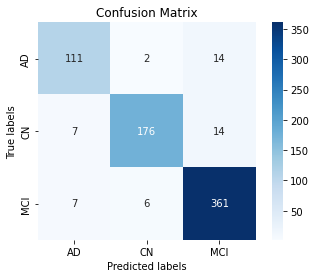

In [ ]:
p = model03.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

**Resnet 50 Row**

In [ ]:
# learning_rate=10E-4
savepath = '/content/drive/MyDrive/ADNI/resnet50_row_10E-4/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-4_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}resnet50_row_10E-4_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/50
698/698 [==============================] - 118s 141ms/step - loss: 5.3829 - Accuracy: 0.4991 - AD_Precision: 0.3287 - CN_Precision: 0.4642 - MCI_Precision: 0.5838 - AD_Recall: 0.2821 - CN_Recall: 0.4316 - MCI_Recall: 0.5711 - val_loss: 1.0405 - val_Accuracy: 0.5258 - val_AD_Precision: 0.3484 - val_CN_Precision: 0.7125 - val_MCI_Precision: 0.7100 - val_AD_Recall: 0.7874 - val_CN_Recall: 0.2893 - val_MCI_Recall: 0.5107
Epoch 2/50
698/698 [==============================] - 96s 138ms/step - loss: 0.9363 - Accuracy: 0.6977 - AD_Precision: 0.6302 - CN_Precision: 0.6880 - MCI_Precision: 0.7481 - AD_Recall: 0.5680 - CN_Recall: 0.6678 - MCI_Recall: 0.7428 - val_loss: 1.2953 - val_Accuracy: 0.5874 - val_AD_Precision: 0.8723 - val_CN_Precision: 0.4463 - val_MCI_Precision: 0.8194 - val_AD_Recall: 0.3228 - val_CN_Recall: 0.9492 - val_MCI_Recall: 0.4733
Epoch 3/50
698/698 [==============================] - 96s 137ms/step - l

              precision    recall  f1-score   support

          AD       0.85      0.84      0.85       127
          CN       0.97      0.88      0.93       197
         MCI       0.91      0.95      0.93       374

    accuracy                           0.91       698
   macro avg       0.91      0.89      0.90       698
weighted avg       0.92      0.91      0.91       698



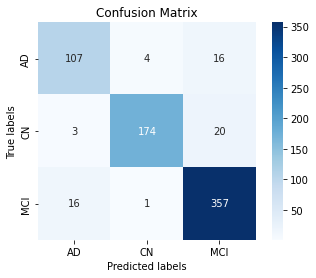

In [ ]:
p = model04.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [ ]:
# learning_rate=10E-5
savepath = '/content/drive/MyDrive/ADNI/resnet50_row_10E-5/'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
698/698 [==============================] - 106s 142ms/step - loss: 6.6077 - Accuracy: 0.5971 - AD_Precision: 0.4219 - CN_Precision: 0.5789 - MCI_Precision: 0.6687 - AD_Recall: 0.4306 - CN_Recall: 0.5580 - MCI_Recall: 0.6757 - val_loss: 3.3094 - val_Accuracy: 0.6562 - val_AD_Precision: 0.5631 - val_CN_Precision: 0.5633 - val_MCI_Precision: 0.7438 - val_AD_Recall: 0.4567 - val_CN_Recall: 0.6548 - val_MCI_Recall: 0.7219
Epoch 2/50
698/698 [==============================] - 98s 141ms/step - loss: 2.4900 - Accuracy: 0.7580 - AD_Precision: 0.6833 - CN_Precision: 0.7388 - MCI_Precision: 0.7953 - AD_Recall: 0.6765 - CN_Recall: 0.7310 - MCI_Recall: 0.8031 - val_loss: 1.7916 - val_Accuracy: 0.7493 - val_AD_Precision: 0.5976 - val_CN_Precision: 0.6850 - val_MCI_Precision: 0.9011 - val_AD_Recall: 0.7953 - val_CN_Recall: 0.8832 - val_MCI_Recall: 0.6578
Epoch 3/50
698/698 [==============================] - 98s 140ms/step - loss: 1.4012 - Accuracy: 0.8347 - AD_Precision: 0.7737 - CN_Precis

              precision    recall  f1-score   support

          AD       0.83      0.98      0.90       127
          CN       0.98      0.90      0.94       197
         MCI       0.96      0.94      0.95       374

    accuracy                           0.93       698
   macro avg       0.92      0.94      0.93       698
weighted avg       0.94      0.93      0.93       698



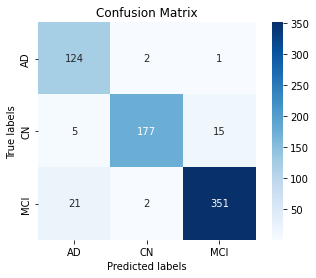

In [ ]:
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [ ]:
# learning_rate=10E-6
savepath = '/content/drive/MyDrive/ADNI/resnet50_row_10E-6/'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-6_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model06 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history06 = model06.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model06 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model06.load_weights(glob.glob(f"{savepath}resnet50_row_10E-6_weights-epoch:*-val_Accuracy:{max(history06.history['val_Accuracy']):.4f}.h5")[0])

Epoch 1/50
698/698 [==============================] - 105s 141ms/step - loss: 2.8186 - Accuracy: 0.5369 - AD_Precision: 0.3495 - CN_Precision: 0.4885 - MCI_Precision: 0.6233 - AD_Recall: 0.3060 - CN_Recall: 0.4648 - MCI_Recall: 0.6541 - val_loss: 1.8575 - val_Accuracy: 0.5473 - val_AD_Precision: 0.4138 - val_CN_Precision: 0.4489 - val_MCI_Precision: 0.6571 - val_AD_Recall: 0.1890 - val_CN_Recall: 0.6244 - val_MCI_Recall: 0.6096
Epoch 2/50
698/698 [==============================] - 97s 139ms/step - loss: 1.5280 - Accuracy: 0.6432 - AD_Precision: 0.4882 - CN_Precision: 0.6211 - MCI_Precision: 0.7138 - AD_Recall: 0.4477 - CN_Recall: 0.6117 - MCI_Recall: 0.7148 - val_loss: 1.3118 - val_Accuracy: 0.6877 - val_AD_Precision: 0.6329 - val_CN_Precision: 0.6890 - val_MCI_Precision: 0.6975 - val_AD_Recall: 0.3937 - val_CN_Recall: 0.5736 - val_MCI_Recall: 0.8262
Epoch 3/50
698/698 [==============================] - 97s 139ms/step - loss: 1.1136 - Accuracy: 0.7401 - AD_Precision: 0.6203 - CN_Precis

              precision    recall  f1-score   support

          AD       0.84      0.84      0.84       127
          CN       0.92      0.85      0.88       197
         MCI       0.90      0.93      0.91       374

    accuracy                           0.89       698
   macro avg       0.88      0.87      0.88       698
weighted avg       0.89      0.89      0.89       698



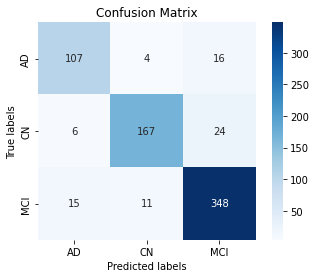

In [ ]:
p = model06.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')